In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install -U albumentations
# !pip install torch

In [3]:
# !pip install torchvision

In [4]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = './folliculitis_3'
DIR_TRAIN = './folliculitis_3\\train'
DIR_TEST = f'{DIR_INPUT}\\test'

In [5]:
train_df=pd.read_csv('./folliculitis_3\\train.csv')

In [6]:
train_df = train_df[train_df.columns[[5,6,7,0,1,2,3,4 ]]]
train_df.columns = ['image_id', 'width', 'height', 'source', 'x','y', 'w', 'h']

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1958 non-null   object
 1   width     1958 non-null   int64 
 2   height    1958 non-null   int64 
 3   source    1958 non-null   object
 4   x         1958 non-null   int64 
 5   y         1958 non-null   int64 
 6   w         1958 non-null   int64 
 7   h         1958 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 122.5+ KB


In [8]:
train_df['image_id']= train_df['image_id'].str.split('.').str[0]

In [9]:
train_df

,image_id,width,height,source,x,y,w,h
0,0013_A2LEBJJDE00060O_1603508849507_5_RH,224,224,pimple,39,90,32,36
1,0425_A2LEBJJDE00079P_1606551499327_6_BH,224,224,pimple,137,137,51,34
2,0425_A2LEBJJDE00079P_1606551499327_6_BH,224,224,pimple,113,86,58,47
3,0556_A2LEBJJDE00041T_1603803173323_3_TH,224,224,pimple,98,47,64,71
4,0616_A2LEBJJDE00004W_1603330599241_4_LH,224,224,pimple,83,34,57,60
...,...,...,...,...,...,...,...,...
1953,gen_0_9979,224,224,pimple,40,60,95,97
1954,gen_0_9981,224,224,pimple,89,116,49,81
1955,gen_0_9987,224,224,pimple,115,135,33,27
1956,gen_0_9992,224,224,pimple,0,84,69,99


In [10]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-100:]
train_ids = image_ids[:-100]

In [11]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [12]:
valid_df

,image_id,width,height,source,x,y,w,h
1844,gen_0_9218,224,224,pimple,42,8,58,113
1845,gen_0_9218,224,224,pimple,131,40,60,100
1846,gen_0_9224,224,224,pimple,27,10,45,76
1847,gen_0_9224,224,224,pimple,101,8,36,108
1848,gen_0_9224,224,224,pimple,135,134,60,53
...,...,...,...,...,...,...,...,...
1953,gen_0_9979,224,224,pimple,40,60,95,97
1954,gen_0_9981,224,224,pimple,89,116,49,81
1955,gen_0_9987,224,224,pimple,115,135,33,27
1956,gen_0_9992,224,224,pimple,0,84,69,99


In [13]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        # image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.imread(f'{self.image_dir}\\{image_id}.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [14]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [15]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [16]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [17]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    # num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    # num_workers=4,
    collate_fn=collate_fn
)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [21]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


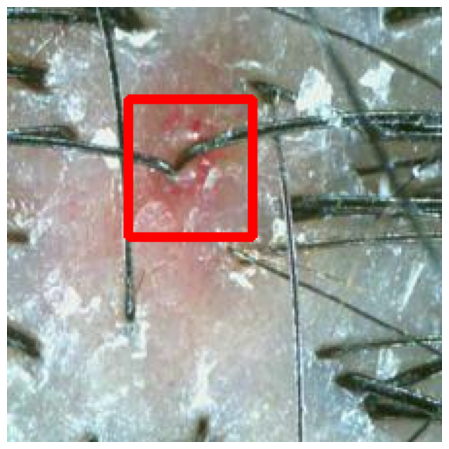

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [24]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")  

Iteration #50 loss: 0.2557626193490024
Iteration #100 loss: 0.2317815258906984
Epoch #0 loss: 0.28545938988295455
Iteration #150 loss: 0.1756412412613038
Iteration #200 loss: 0.21649792970630688
Epoch #1 loss: 0.23010948985411314


In [25]:
images, targets, image_ids = next(iter(valid_data_loader))

In [26]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [27]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


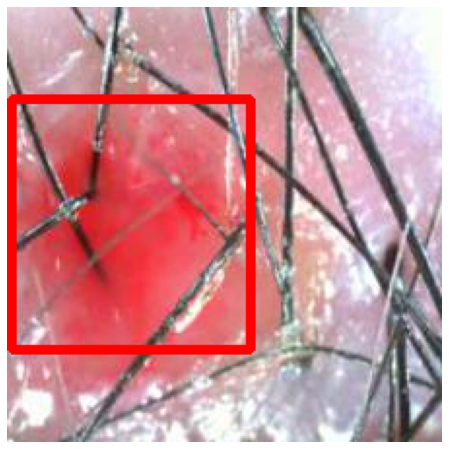

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [29]:
torch.save(model, 'fasterrcnn_restet50.pt')

In [29]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

---

In [65]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')

In [66]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]


In [67]:
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [68]:
test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [69]:
model.eval()

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        
            
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

RuntimeError: DataLoader worker (pid(s) 36820, 36376, 32412, 25492) exited unexpectedly

---

In [42]:
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [46]:
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

In [43]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

#dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, './folliculitis_3/test/')

#data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [44]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [51]:
with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

FileNotFoundError: [Errno 2] No such file or directory: 'test_annotations/gen_0_5425.xml'

In [48]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

NameError: name 'annotations' is not defined